# word2vec: a small model with a big idea

## From Documents to Windows

While TF-IDF gave us our first glimpse into distributed word representations, it had a fundamental limitation: it only considered document-level context. But language has rich structure at much finer scales. Word2Vec, introduced by Mikolov et al. in 2013 {footcite}`mikolov2013distributed`, revolutionized word embeddings by focusing on local context windows.

Instead of looking at entire documents, Word2Vec looks at small windows of text, typically 5-10 words wide. For example, in the sentence "The cat chases mice in the garden", with a window size of 2, the context for "chases" would be ["The", "cat", "mice", "in"].

```{note}
This shift from document-level to window-level context was revolutionary. It allowed the model to capture more nuanced relationships between words, as words that appear in similar immediate contexts often have similar grammatical roles or semantic meanings.
```

## Learning from Co-occurrence

Like TF-IDF, Word2Vec is fundamentally about learning from patterns of word co-occurrence. However, instead of creating a large sparse matrix of word-document counts, Word2Vec learns dense vector representations directly through a prediction task.

There are two main variants:
- **CBOW (Continuous Bag of Words)** works like that fill-in-the-blank test. For example:
  `The _____ chases mice in the garden`
This is similar to how we learn language - by understanding which words make sense in a given context. CBOW takes the surrounding context words and uses them to predict the center word that would make sense in that context.
- **Skip-gram** is a much more challenging task. It tries to predict the surrounding context words given a center word. For example: `_____ cat _____ _____ _____ _____ `. Note that the order of the context words does not matter, i.e., Skip-gram predicts the set of context words, so "{garden, in, the, mice, chases, The}" is equally correct as "{cat, in, the, mice, chases, The}".


## Neural network representation

word2vec can be represented as a neural network with a single hidden layer as follows.

- **Input layer**: The input layer consists of $N$ neurons, where $N$ is the size of the vocabulary (i.e., the number of unique words in the corpus). Each neuron corresponds to a unique word in the vocabulary. When a word is inputted, its corresponding neuron is activated and the other neurons are inhibited. Thus, the input layer is essentially a lookup mechanism that transforms the input word into a corresponding one-hot vector.

- **Output layer**: The output layer also consists of $N$ neurons, each corresponding to a unique word in the vocabulary. Unlike the input layer, multiple neurons can be activated for a single input. The strength of the activation of each neuron (with a normalization by the softmax function) represents the probability of the corresponding word being the input word's context.

- **Hidden layer**: The hidden layer is much smaller than the input and output layers. Multiple neurons in the hidden layer can be activated for a single input, and this activation pattern represents the word's *embedding*.

![](../figs/word2vec.jpg)


### Skip-gram Model

In the Skip-gram model, given a word, we try to predict the probability of seeing each possible context word. Specifically, for a center word $w_c$ and a context word $w_o$, we want:

$P(w_o|w_c) = \dfrac{\exp(v_{w_o}^T v_{w_c})}{\sum_{w \in V} \exp(v_w^T v_{w_c})}$

where:
- $v_{w_c}$ is the vector representation of the center word
- $v_{w_o}$ is the vector representation of the output word
- $V$ is the vocabulary

```{note}
Notice the softmax function in the equation. This transforms the raw dot product scores into proper probabilities that sum to 1. However, this normalization over the entire vocabulary becomes computationally expensive for large vocabularies.
```

### CBOW Model

CBOW works in the opposite direction, predicting the center word from the context. For context words $w_{1}, ..., w_{C}$, we have:

$$
P(w_c|w_1,...,w_C) = \dfrac{\exp(v_{w_c}^T \bar{v})}{\sum_{w \in V} \exp(v_w^T \bar{v})},
$$

where $\bar{v} = \dfrac{1}{C}\sum_{i=1}^C v_{w_i}$ is the average of the context word vectors.



## The Matrix Factorization Connection

word2vec can be represented as a neural network with a single hidden layer as follows. So it appears to be different from the word embedding we constructed using tf-idf matrix factorization. However, word2vec implicitly factorizes a matrix {footcite}`levy2014neural` as follows.

$$
M = (M_{ij}), \quad M_{ij} = \log \dfrac{P(w_i,  w_j)}{P(w_j)P(w_j)}
$$

where $M$ is the matrix that word2vec implicitly factorizes. $M_{ij}$ is called the *pointwise mutual information* between words $w_i$ and $w_j$. $M_{ij}$ is the smallest when $w_i$ and $w_j$ appear independently, and the largest when $w_i$ and $w_j$ always appear together. Likewise tf-idf, it normalizes the mere co-occurrence counts ($P(w_i, w_j)$) by the probabilities of the words ($P(w_i)$ and $P(w_j)$), creating a similar effect as tf-idf.

Word embeddings learned by word2vec are essentially constructed by factorizing the pointwise mutual information matrix, and the similarity between words approximately preserves the PMI values.

$$
v_{w_i} ^\top v_{w_j} \approx M_{ij}
$$

This means that words that frequently co-appear in the same context tend to be similar to each other (a high PMI value), and vice versa.

```{tip}
This connection to matrix factorization helps explain why Word2Vec works: it's finding a low-dimensional representation that captures the essential patterns in word co-occurrence statistics, just like how PCA finds low-dimensional representations that capture variance in data.
```

## The Softmax Challenge

The above approximation is only valid when the embedding dimension is sufficiently large. Adding softmax transforms the problem from simple matrix factorization into a Boltzmann machine. While this gives us proper probabilities, it introduces a major computational challenge: computing the normalization constant requires summing over the entire vocabulary.
For a vocabulary of 100,000 words, this means computing 100,000 exponentials for every prediction!

### Hierarchical Softmax: A Clever Solution

To make training feasible, Word2Vec uses hierarchical softmax. Instead of computing probabilities over the entire vocabulary at once, it:

1. Arranges words in a binary tree (usually a Huffman tree)
2. Transforms the prediction problem into a sequence of binary decisions
3. Reduces computation from O(|V|) to O(log|V|)

```{note}
This is similar to how you might play "20 questions" to guess a word. Each question splits the possible answers in half, making the process much more efficient than checking each possibility one by one.
```

## Impact and Legacy

Word2Vec demonstrated that meaningful word representations could be learned from local context alone, without requiring expensive annotation or linguistic expertise. Its success inspired many subsequent developments in NLP, including:

- GloVe: Combining the benefits of matrix factorization and local context
- FastText: Adding subword information to handle out-of-vocabulary words
- Contextual embeddings like BERT: Learning dynamic representations that change based on context

```{tip}
The principles behind Word2Vec - learning from context and using clever approximations to handle scale - continue to influence modern NLP architectures. Even large language models like GPT can be seen as sophisticated extensions of these basic ideas.
```

## Hands-on with word2vec

With word2vec, words are represented as dense vectors, enabling us to explore their relationships using simple linear algebra. This is in contrast to traditional natural language processing (NLP) methods, such as bag-of-words and topic modeling, which represent words as discrete units or high-dimensional vectors.


![](https://miro.medium.com/v2/resize:fit:678/1*5F4TXdFYwqi-BWTToQPIfg.jpeg)

To showcase the effectiveness of word2vec, let's walk through an example using the `gensim` library.

In [1]:
import gensim
import gensim.downloader
from gensim.models import Word2Vec

# Load pre-trained word2vec model from Google News
model = gensim.downloader.load('word2vec-google-news-300')

Our first example is to find the words most similar to *king*.

In [2]:
# Example usage
word = "king"
similar_words = model.most_similar(word)
print(f"Words most similar to '{word}':")
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity:.4f}")

Words most similar to 'king':
kings: 0.7138
queen: 0.6511
monarch: 0.6413
crown_prince: 0.6204
prince: 0.6160
sultan: 0.5865
ruler: 0.5798
princes: 0.5647
Prince_Paras: 0.5433
throne: 0.5422


A cool (yet controversial) application of word embeddings is analogy solving. Let us consider the following puzzle:

> *man* is to *woman* as *king* is to ___ ?

We can use word embeddings to solve this puzzle.

In [3]:
# We solve the puzzle by
#
#  vec(king) - vec(man) + vec(woman)
#
# To solve this, we use the model.most_similar function, with positive words being "king" and "woman" (additive), and negative words being "man" (subtractive).
#
model.most_similar(positive=['woman', "king"], negative=['man'], topn=5)

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133)]

The last example is to visualize the word embeddings.

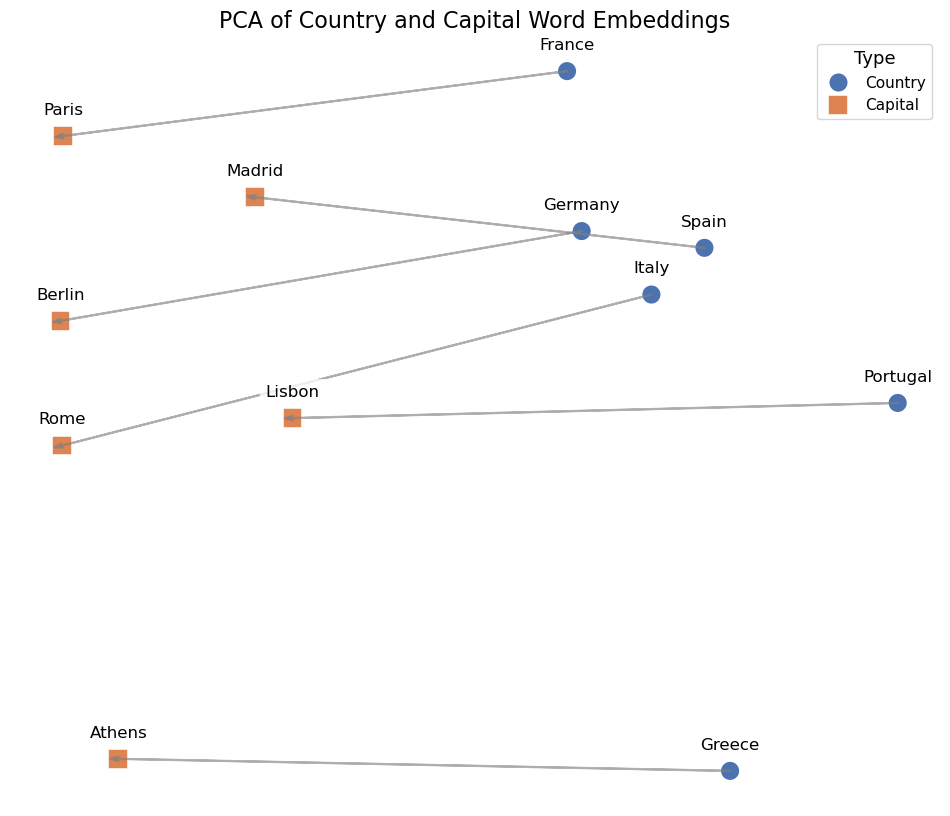

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

countries = ['Germany', 'France', 'Italy', 'Spain', 'Portugal', 'Greece']
capital_words = ['Berlin', 'Paris', 'Rome', 'Madrid', 'Lisbon', 'Athens']

# Get the word embeddings for the countries and capitals
country_embeddings = np.array([model[country] for country in countries])
capital_embeddings = np.array([model[capital] for capital in capital_words])

# Compute the PCA
pca = PCA(n_components=2)
embeddings = np.vstack([country_embeddings, capital_embeddings])
embeddings_pca = pca.fit_transform(embeddings)

# Create a DataFrame for seaborn
df = pd.DataFrame(embeddings_pca, columns=['PC1', 'PC2'])
df['Label'] = countries + capital_words
df['Type'] = ['Country'] * len(countries) + ['Capital'] * len(capital_words)

# Plot the data
plt.figure(figsize=(12, 10))

# Create a scatter plot with seaborn
scatter_plot = sns.scatterplot(data=df, x='PC1', y='PC2', hue='Type', style='Type', s=200, palette='deep', markers=['o', 's'])

# Annotate the points
for i in range(len(df)):
    plt.text(df['PC1'][i], df['PC2'][i] + 0.08, df['Label'][i], fontsize=12, ha='center', va='bottom',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

# Draw arrows between countries and capitals
for i in range(len(countries)):
    plt.arrow(df['PC1'][i], df['PC2'][i], df['PC1'][i + len(countries)] - df['PC1'][i], df['PC2'][i + len(countries)] - df['PC2'][i],
              color='gray', alpha=0.6, linewidth=1.5, head_width=0.02, head_length=0.03)

plt.legend(title='Type', title_fontsize='13', fontsize='11')
plt.title('PCA of Country and Capital Word Embeddings', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
ax = plt.gca()
ax.set_axis_off()

We can see that word2vec places the words representing countries close to each other and so do the words representing their capitals. The country-capital relationship is also roughly preserved, e.g., *Germany*-*Berlin* vector is roughly parallel to *France*-*Paris* vector.



## 🔥🔥 Exercise 🔥🔥

1. Using the word2vec model, find the 5 most similar words to "computer" and "science". What do you observe about the semantic relationships between these words?

2. Perform the following word analogy tasks using word2vec and explain your findings:
   - man : woman :: king : ?
   - Paris : France :: Tokyo : ?
   - car : cars :: child : ?

3. Create a visualization similar to the country-capital example above but using:
   - Different professions and their typical workplaces (e.g., doctor-hospital, teacher-school)
   - Different languages and their countries (e.g., Spanish-Spain, French-France)

   Compare the patterns you observe with the country-capital relationships.

4. Advanced: Investigate the concept of "gender bias" in word embeddings:
   - Find the vector difference between pairs like "he-she", "man-woman", "king-queen"
   - Project profession words (e.g., "doctor", "nurse", "engineer", "teacher") onto these gender directions
   - What does this tell us about potential biases in the training data?




```{footbibliography}

```